In [8]:
#!pip install tensorflow
import keras
from tensorflow.keras.preprocessing.text import Tokenizer # Use tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Use tensorflow.keras
from tensorflow.keras.layers import Dropout # Import Dropout layer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Importando dataset
df = pd.read_csv('IMDB Dataset.csv')
print(df.head())
print(df.describe())
print(df.info())

# Preprocesamiento de las secuencias
review = []
sentences = list(df['review'])
for sen in sentences:
    review.append(sen)

# Preprocesamiento de las secuencias
labels = df['sentiment']
labels = np.array(list(map(lambda x: 1 if x=="positive" else 0, labels)))

# Preprocesamiento de las secuencias
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(review, labels, test_size=0.20, random_state=42)

# Parametros
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# inicializar la clase tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

# Generar el diccionario de indices de palabras para el entrenamiento de las frases
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generar y hacer pad a las secuencias entrenadas
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Generar y hacer pad a las secuencias de prueba
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))


# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels.flatten() == test_labels)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

f1 = f1_score(test_labels, predicted_labels)
print(f"F1-score: {f1}")

cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_proba = model.predict(testing_padded)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

errors = predicted_labels.flatten() - test_labels
plt.hist(errors, bins=10)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

Preguntas:

1. ¿Qué tipo de modelo de red neuronal se construye en el código?
El modelo de red neuronal que se construye en el código es una Red Neuronal Recurrente (RNN), específicamente una variante llamada Long Short-Term Memory (LSTM).

Este tipo de red es especialmente útil para procesar secuencias de datos, como texto, ya que tiene la capacidad de "recordar" información de pasos anteriores en la secuencia.

En este caso, el modelo LSTM se utiliza para analizar el sentimiento de las reseñas de películas.
2. ¿Cuál es la función de activación utilizada en la capa de salida y por qué se elige esta función para este problema?
La función de activación utilizada en la capa de salida es la función sigmoide ('sigmoid').

Se elige esta función porque el problema es de clasificación binaria (positivo o negativo). La función sigmoide produce valores entre 0 y 1, que pueden interpretarse como probabilidades.

Un valor cercano a 1 indica una alta probabilidad de que la reseña sea positiva, mientras que un valor cercano a 0 indica una alta probabilidad de que sea negativa.
3. ¿Cuál es la diferencia entre una capa LSTM bidireccional y una capa LSTM unidireccional?
La principal diferencia radica en cómo procesan la información de la secuencia:

LSTM Unidireccional: Procesa la secuencia en una sola dirección, de principio a fin. En cada paso de tiempo, la capa recibe información del paso anterior y la utiliza para actualizar su estado interno.

LSTM Bidireccional: Procesa la secuencia en ambas direcciones, de principio a fin y de fin a principio, utilizando dos capas LSTM separadas. Esto permite a la capa considerar el contexto tanto pasado como futuro de cada elemento en la secuencia, lo que puede mejorar la precisión en ciertas tareas.

En resumen, una LSTM bidireccional puede capturar dependencias a largo plazo en ambas direcciones de la secuencia, lo que puede ser beneficioso para tareas como el análisis de sentimiento, donde el significado de una palabra puede depender de las palabras que la preceden y la siguen.
4. ¿Qué significan los parámetros return_sequences=True en la primera capa LSTM bidireccional?
El parámetro return_sequences=True en la primera capa LSTM significa que la capa devolverá una secuencia de salidas, una para cada paso de tiempo en la secuencia de entrada, en lugar de solo la salida del último paso de tiempo.

Esto es necesario cuando se apilan múltiples capas LSTM, ya que la siguiente capa LSTM espera recibir una secuencia como entrada.

En este caso, al establecer return_sequences=True en la primera capa LSTM, la segunda capa LSTM puede procesar la información de cada paso de tiempo de la primera capa, lo que permite capturar dependencias más complejas en la secuencia.
5. ¿Qué función de pérdida se utiliza en el modelo y por qué es adecuada para problemas de clasificación binaria?
La función de pérdida utilizada en el modelo es 'binary_crossentropy' (entropía cruzada binaria).

Esta función es adecuada para problemas de clasificación binaria porque mide la diferencia entre la distribución de probabilidad predicha por el modelo y la distribución real de las etiquetas.

En otras palabras, penaliza al modelo cuando predice una alta probabilidad para la clase incorrecta y lo recompensa cuando predice una alta probabilidad para la clase correcta.

Esto ayuda al modelo a aprender a distinguir entre las dos clases y a mejorar su precisión en la clasificación.
6. ¿Qué métrica se utiliza para evaluar el rendimiento del modelo durante el entrenamiento?
La métrica utilizada para evaluar el rendimiento del modelo durante el entrenamiento es 'accuracy' (precisión).

Esta métrica mide el porcentaje de predicciones correctas realizadas por el modelo en el conjunto de datos de entrenamiento.

Es una métrica comúnmente utilizada en problemas de clasificación, ya que proporciona una medida intuitiva del rendimiento del modelo.

Sin embargo, es importante tener en cuenta que la precisión puede ser engañosa en conjuntos de datos desequilibrados, donde una clase es mucho más frecuente que la otra. En tales casos, se pueden utilizar otras métricas como la precisión, la recuperación o el puntaje F1 para evaluar el rendimiento del modelo de manera más completa.
7. ¿Por qué se utilizan dos capas LSTM bidireccionales en el modelo?
Utilizar dos capas LSTM bidireccionales en el modelo, en lugar de una, puede ayudar a capturar dependencias más complejas y a largo plazo en la secuencia de datos.

Cada capa LSTM puede aprender diferentes patrones y representaciones de la secuencia, y al apilarlas, el modelo puede combinar estas representaciones para obtener una comprensión más profunda de los datos.

La primera capa LSTM procesa la secuencia de entrada y genera una secuencia de salidas, que luego se utiliza como entrada para la segunda capa LSTM.

Esta segunda capa puede entonces refinar las representaciones aprendidas por la primera capa y capturar dependencias más complejas que no fueron capturadas por la primera capa.

En general, apilar capas LSTM puede mejorar la capacidad del modelo para aprender patrones complejos en secuencias de datos, lo que puede llevar a un mejor rendimiento en tareas como el análisis de sentimiento.
8. ¿Qué hace la capa de embedding en el modelo y por qué es necesaria?
La capa de embedding en el modelo transforma las palabras de entrada, representadas como índices enteros, en vectores densos de baja dimensión.

Estos vectores, también conocidos como embeddings, capturan el significado semántico de las palabras y su relación con otras palabras en el vocabulario.

La capa de embedding es necesaria porque permite al modelo procesar palabras como entradas numéricas continuas, en lugar de tratarlas como entidades discretas sin relación entre sí.

Los embeddings aprendidos por la capa de embedding pueden capturar relaciones semánticas entre palabras, como sinónimos, antónimos y analogías.

Esto permite al modelo generalizar mejor a nuevas palabras y frases que no se vieron durante el entrenamiento, y mejorar su capacidad para comprender el significado del texto.

En resumen, la capa de embedding es crucial para el rendimiento del modelo en tareas de procesamiento de lenguaje natural.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 114ms/step - accuracy: 0.5100 - loss: 0.6937 - val_accuracy: 0.4961 - val_loss: 0.6934
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 200s 112ms/step - accuracy: 0.5103 - loss: 0.6918 - val_accuracy: 0.6249 - val_loss: 0.6681
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 109ms/step - accuracy: 0.7262 - loss: 0.5486 - val_accuracy: 0.8326 - val_loss: 0.3806
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 104ms/step - accuracy: 0.8619 - loss: 0.3291 - val_accuracy: 0.8439 - val_loss: 0.3651
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.8909 - loss: 0.2709 - val_accuracy: 0.8484 - val_loss: 0.3490
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - accuracy: 0.9034 - loss: 0.2438 - val_accuracy: 0.8428 - val_loss: 0.3682
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.9161 - loss: 0.2181 - val_accuracy: 0.8403 - val_loss: 0.3803
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - ac

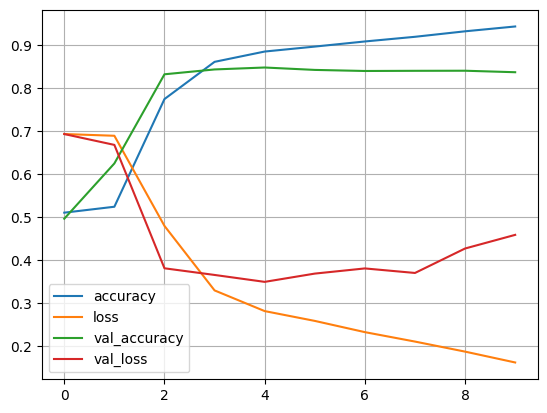

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
Precisión del modelo: 83.74%
F1-score: 0.8361877896433608
[[4224  737]
 [ 889 4150]]


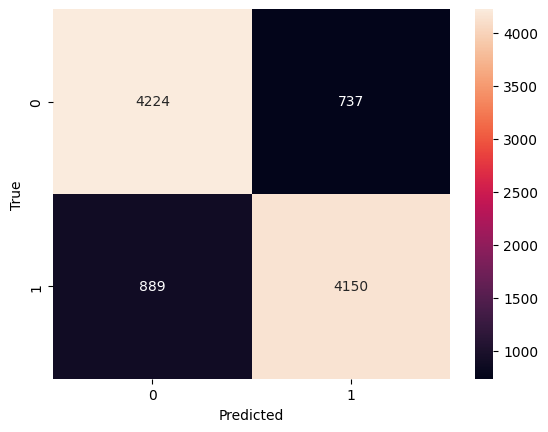

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


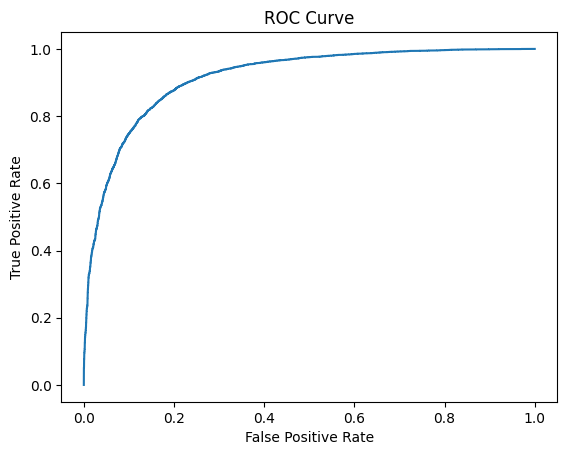

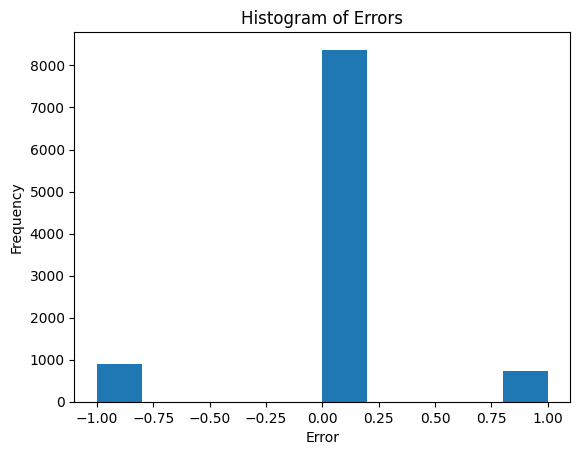

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))


# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels.flatten() == test_labels)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

f1 = f1_score(test_labels, predicted_labels)
print(f"F1-score: {f1}")

cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_proba = model.predict(testing_padded)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

errors = predicted_labels.flatten() - test_labels
plt.hist(errors, bins=10)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 344s 270ms/step - accuracy: 0.4977 - loss: 0.6938 - val_accuracy: 0.5039 - val_loss: 0.6932
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 401s 286ms/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.4961 - val_loss: 0.6932
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 335s 268ms/step - accuracy: 0.4900 - loss: 0.6933 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 396s 279ms/step - accuracy: 0.5009 - loss: 0.6933 - val_accuracy: 0.4961 - val_loss: 0.6932
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 366s 266ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.4961 - val_loss: 0.6933
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 332s 266ms/step - accuracy: 0.5067 - loss: 0.6932 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 381s 265ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 383s 266ms/step - ac

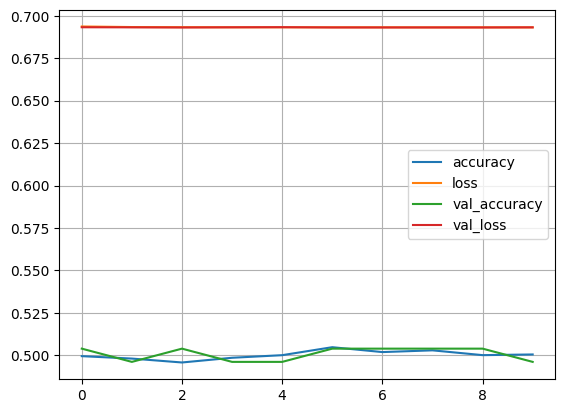

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step
Precisión del modelo: 49.61%
F1-score: 0.0
[[4961    0]
 [5039    0]]


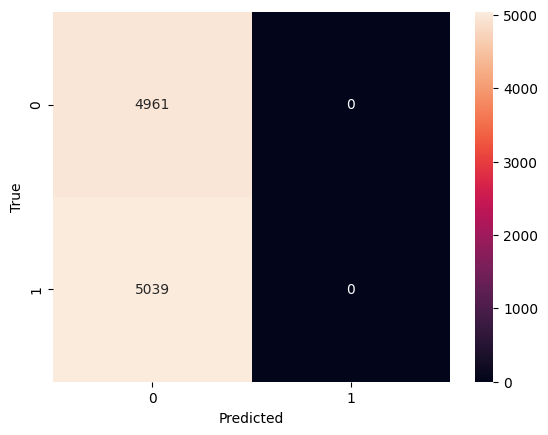

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step


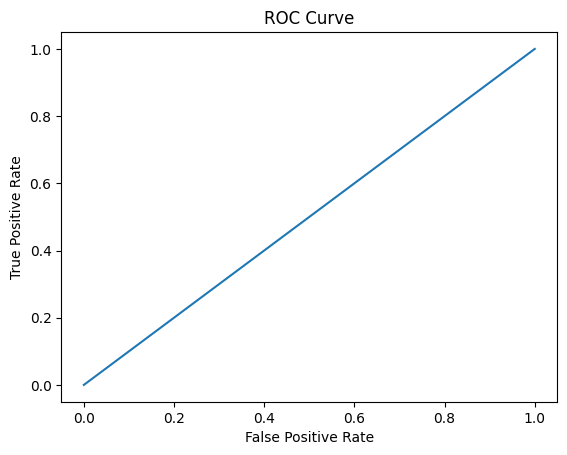

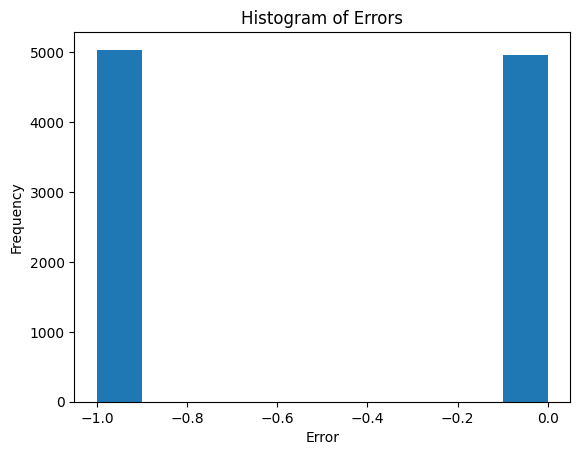

In [9]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(128, return_sequences=True),
    Dropout(0.25),
    keras.layers.LSTM(64, return_sequences=True), # Add return_sequences=True
    Dropout(0.25),
    keras.layers.LSTM(32),
    Dropout(0.25),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))


# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels.flatten() == test_labels)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

f1 = f1_score(test_labels, predicted_labels)
print(f"F1-score: {f1}")

cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_proba = model.predict(testing_padded)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

errors = predicted_labels.flatten() - test_labels
plt.hist(errors, bins=10)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()